# Mapping Genre Taxonomies

*Matthew Greenlees*

This is the source code for the first assignment of the Audio and Music Processing Lab of the Sound and Music Computing Master.

To run this notebook, you need to put it in the same directory as the four .tsv files.

We begin by importing the required libraries.

In [1]:
import csv
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

We need to find the mbids of the songs that are present in all four of the files. To do that, we use the function `find_intersection`.

In [2]:
def find_intersection():
    """
    This function finds the intersetion of the four genre sources, and returns the 
    list of recordingmbids as a set. Works for both tasks 1 and 2.
    """
    # create a list of the sources
    sources = ['tagtraum', 'lastfm', 'discogs', 'allmusic']

    for s in sources: 
        # create the path to the file
        path = './acousticbrainz-mediaeval2017-' + s + '-train.tsv'
        
        # create an empty set that we will add to
        row_ids_temp = set()
        
        with open(path) as f:
            # as we are using a .tsv file, we have to use \t as our delimiter
            reader = csv.reader(f, delimiter = '\t')
            
            # this skips the header so we don't read it into our list
            next(reader)
            
            # read in each row, one at a time, then add the first column to a list
            for line in reader:
                row_ids_temp.add(line[0])
        
        # find the intersection of the four files, one source at a time
        if s == 'tagtraum':
            row_ids = set(row_ids_temp)
        else:
            row_ids = row_ids & set(row_ids_temp)

    return row_ids

Then we need to create a file `annotate.csv` that contains the songs that are in the intersection with the subgenres annotated as a string "sourcename---genrename---subgenrename". To do that, we use the function `annotate` that takes as input the output of `find_intersection`.

In [3]:
def annotate(row_ids: set):
    """
    Takes the row_ids and each of the four souces and creates a new file annotated.csv that
    that labels each song as source-genre-subgenre.
    """
    
    sources = ['tagtraum', 'lastfm', 'discogs', 'allmusic']
    new_path = './annotated.csv'
    
    with open(new_path, 'w', newline = '') as f:
        # this overwrites any previous file
        pass

    with open(new_path, 'a', newline = '') as new_f:
        writer = csv.writer(new_f)
        
        for s in sources:
            path = './acousticbrainz-mediaeval2017-' + s + '-train.tsv'
            
            with open(path, 'r') as old_f:
                reader = csv.reader(old_f, delimiter = '\t')
                
                # skip the header of the csv
                next(reader)
                
                for line in reader:
                    if line[0] in row_ids:
                        # Create a list that contains the mbid of the current
                        # row. If the current genre has any subgenre tags, then
                        # we will add them to the list too. If the current track
                        # has no subgenres, then we don't add it to the new file.
                        list_to_add = [line[0]]
                        add_list = False
                        for genre in line[2 : ]:
                            if '---' in genre:
                                add_list = True
                                list_to_add.append(s + '---' + genre)
                        if add_list:
                            writer.writerow(list_to_add)

Now, we remove the subgenres that occur below a given threshold. To do that, we use the function `remove_tracks_below_threshold` which takes as an argument the threshold.

In [4]:
def remove_tracks_below_threshold(threshold: int):
    """
    Takes in a threshold and creates a new csv annotated-reduced.csv that is the same as 
    annotated.csv but without the subgenres that have occurances less than the given threshold.
    """

    # Create two empty dictionarys that will count the subgenres and also record the ones
    # that are above the cut. The first will be used to count the number of instances of
    # each subgenre.
    dict_of_subgenres = {}
    dict_of_subgenres_above_threshold = {}
    
    old_path = './annotated.csv'
    new_path = './annotated-reduced.csv'
    
    # create a new set of row_ids that only includes the ones that are in annotated.csv
    new_row_ids = set()
    
    with open(old_path) as f:
        reader = csv.reader(f)
        
        # count the number of occurunces of each subgenre
        for line in reader:
            for subgenre in line[1 : ]:
                if subgenre in dict_of_subgenres:
                    dict_of_subgenres[subgenre] += 1
                else:
                    dict_of_subgenres[subgenre] = 1
    
    with open(old_path) as old_f:
        with open(new_path, 'w', newline = '') as new_f:
            reader = csv.reader(old_f)
            writer = csv.writer(new_f)
            
            for line in reader:
                # create a list which contains the mbid of the track
                list_to_add = [line[0]]
                for subgenre in line[1 : ]:
                    #if dict_of_subgenres[subgenre] >= threshold and 'metal' in subgenre:
                    if dict_of_subgenres[subgenre] >= threshold:
                        list_to_add.append(subgenre)
                        dict_of_subgenres_above_threshold[subgenre] = dict_of_subgenres[subgenre]
                
                # if the song has at least one subgenre, then add it
                if len(list_to_add) > 1:
                    writer.writerow(list_to_add)
                    new_row_ids.add(line[0])
    
    return new_row_ids, dict_of_subgenres_above_threshold

We now create a function **create_matrix** that creates a track-subgenre occurrence matrix, where row $i$ and column $j$ is labelled 1 if track $i$ is tagged with genre $j$. It then returns a condensed matrix $D$ and a list containing the subgenres in the correct order, so that the $j^{\text{th}}$ element of the list is subgenre $j$ in the matrix.

In [5]:
def create_matrix(new_row_ids: set, dict_of_subgenres: dict):
    
    num_tracks = len(new_row_ids)
    num_subgenres = len(dict_of_subgenres)
    
    # first, create an empty numpy array which we will add to later
    X = np.zeros((num_tracks, num_subgenres), dtype = int)
    
    # create empty distance matrix of same size
    D = np.zeros((num_tracks, num_subgenres))
    
    counter = 0
    
    # label each subgenre with a number to label the dendrogram
    for subgenre in dict_of_subgenres:
        dict_of_subgenres[subgenre] = counter
        counter += 1
    
    counter = 0
    row_ids_numbers = {}
    
    for track_id in new_row_ids:
        row_ids_numbers[track_id] = counter
        counter += 1
    
    with open('./annotated-reduced.csv') as f:
        reader = csv.reader(f)
        
        for line in reader:
            x = row_ids_numbers[line[0]]
            for subgenre in line[1 : ]:
                y = dict_of_subgenres[subgenre]
                X[x, y] = 1
    D = pdist(X.T, metric = 'cosine')
    
    counter = 0
    label_list = []
    
    while counter < len(dict_of_subgenres):
        for i in dict_of_subgenres:
            if dict_of_subgenres[i] == counter:
                label_list.append(i)
                counter += 1
    
    return D, label_list

We are then ready to put it all together.

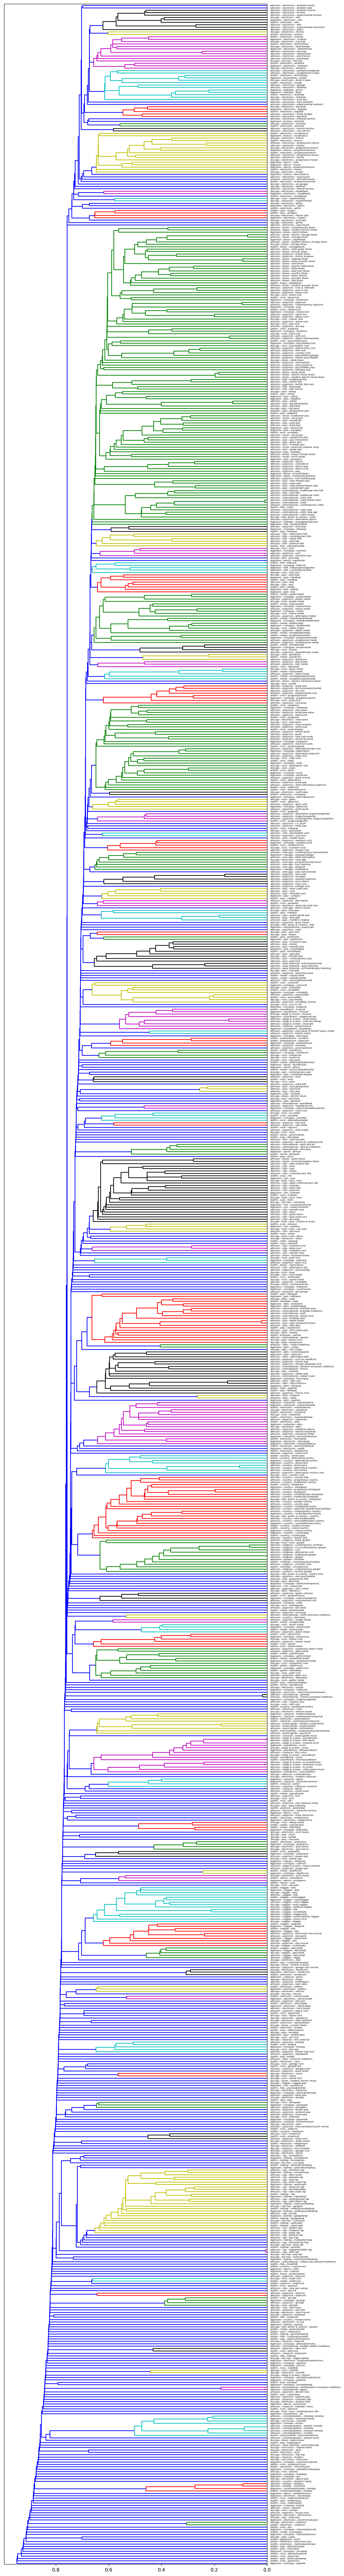

In [6]:
# find the intersection of the four datasets and save the song mbids in a list
row_ids = find_intersection()

# create a csv called annotate.csv
annotate(row_ids)

# remove the tracks below threshold
new_row_ids, small_dict_of_subgenres = remove_tracks_below_threshold(200)

# find the matrix D and it's corresponding list of subgenre labels
D, label_list = create_matrix(new_row_ids, small_dict_of_subgenres)

# perform hierarchical/agglomerative clustering
Z = linkage(D, metric = 'cosine')

# plot the dendrogram and save it as a pdf
fig = plt.figure(figsize = (10, 100), dpi = 160, facecolor = 'w', edgecolor = 'k')
#fig = plt.figure(figsize = (10, 15), dpi = 160, facecolor = 'w', edgecolor = 'k')
dendrogram(Z, orientation = 'left', labels = label_list) # add labels
plt.savefig('dendrogram.pdf', bbox_inches = 'tight')
plt.show()

Then we want to change the function so that we can analyse metal and electronic music specifically.

In [7]:
def remove_tracks_below_threshold_extended(threshold: int, word: str):
    """
    Takes in a threshold and creates a new csv annotated-reduced.csv that is the same as 
    annotated.csv but without the subgenres that have occurances less than the given threshold.
    """

    # Create two empty dictionarys that will count the subgenres and also record the ones
    # that are above the cut. The first will be used to count the number of instances of
    # each subgenre.
    dict_of_subgenres = {}
    dict_of_subgenres_above_threshold = {}
    
    old_path = './annotated.csv'
    new_path = './annotated-reduced.csv'
    
    # create a new set of row_ids that only includes the ones that are in annotated.csv
    new_row_ids = set()
    
    with open(old_path) as f:
        reader = csv.reader(f)
        
        # count the number of occurunces of each subgenre
        for line in reader:
            for subgenre in line[1 : ]:
                if subgenre in dict_of_subgenres:
                    dict_of_subgenres[subgenre] += 1
                else:
                    dict_of_subgenres[subgenre] = 1
    
    with open(old_path) as old_f:
        with open(new_path, 'w', newline = '') as new_f:
            reader = csv.reader(old_f)
            writer = csv.writer(new_f)
            
            for line in reader:
                # create a list which contains the mbid of the track
                list_to_add = [line[0]]
                for subgenre in line[1 : ]:
                    if dict_of_subgenres[subgenre] >= threshold and word in subgenre:
                        list_to_add.append(subgenre)
                        dict_of_subgenres_above_threshold[subgenre] = dict_of_subgenres[subgenre]
                
                # if the song has at least one subgenre, then add it
                if len(list_to_add) > 1:
                    writer.writerow(list_to_add)
                    new_row_ids.add(line[0])
    
    return new_row_ids, dict_of_subgenres_above_threshold

Now, we run this function with the word 'metal'.

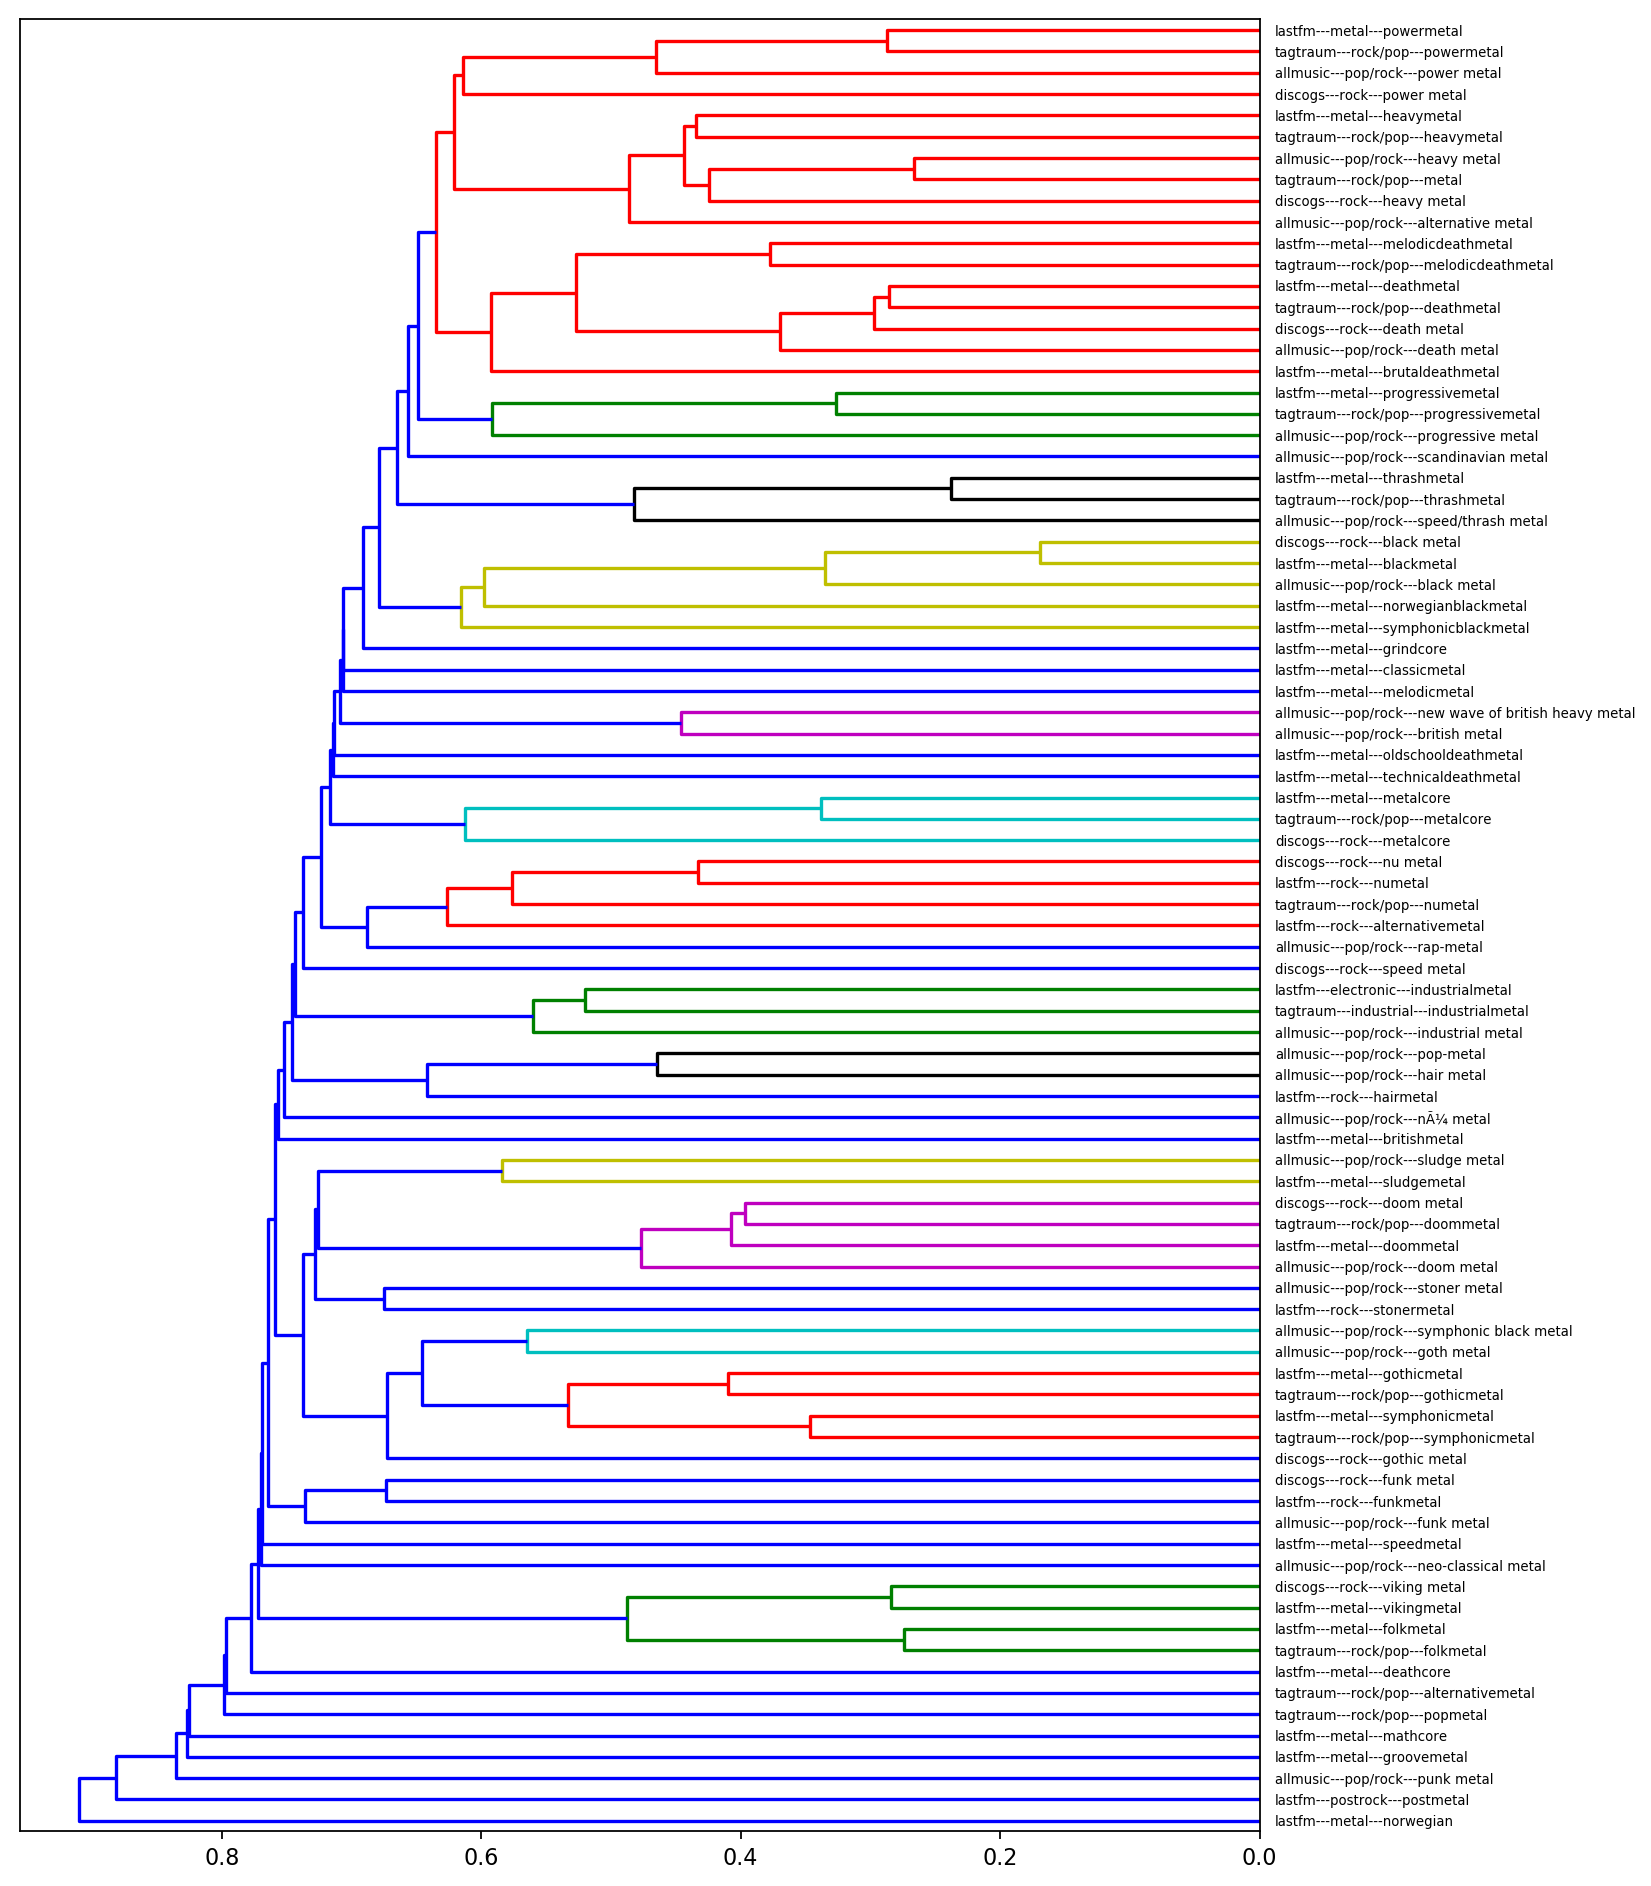

In [8]:
# remove the tracks below threshold
new_row_ids, small_dict_of_subgenres = remove_tracks_below_threshold_extended(200, 'metal')

# find the matrix D and it's corresponding list of subgenre labels
D, label_list = create_matrix(new_row_ids, small_dict_of_subgenres)

# perform hierarchical/agglomerative clustering
Z = linkage(D, metric = 'cosine')

# plot the dendrogram and save it as a pdf
#fig = plt.figure(figsize = (10, 100), dpi = 80, facecolor = 'w', edgecolor = 'k')
fig = plt.figure(figsize = (10, 15), dpi = 160, facecolor = 'w', edgecolor = 'k')
dendrogram(Z, orientation = 'left', labels = label_list) # add labels
plt.savefig('dendrogram2.png', bbox_inches = 'tight')
plt.show()

We run the program again with the word 'electronic'.

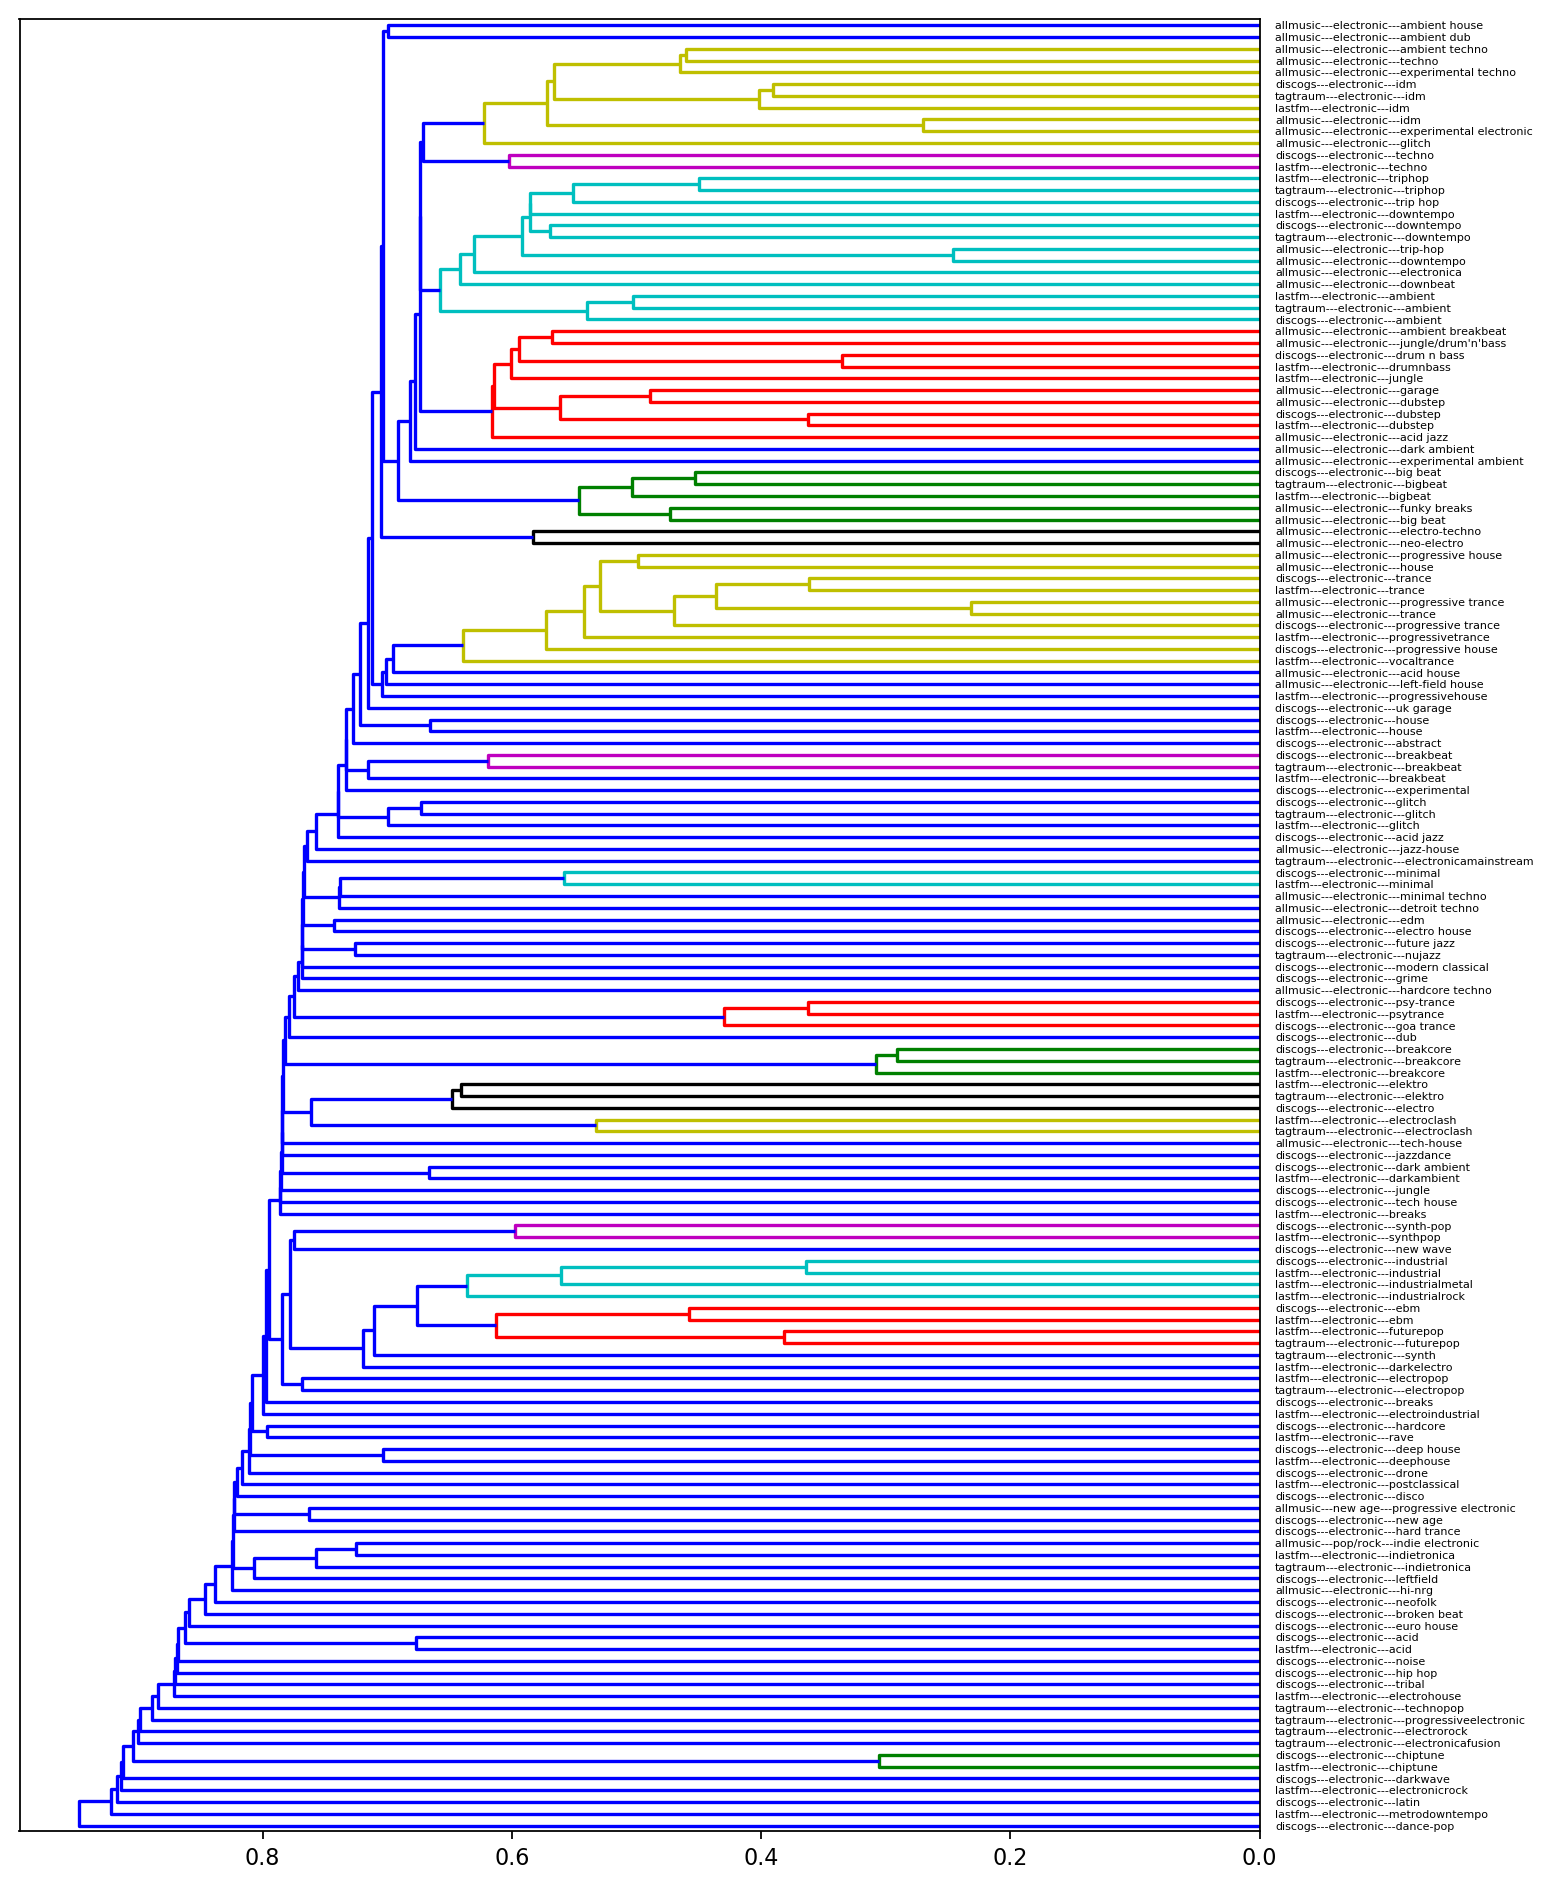

In [9]:
# remove the tracks below threshold
new_row_ids, small_dict_of_subgenres = remove_tracks_below_threshold_extended(200, 'electronic')

# find the matrix D and it's corresponding list of subgenre labels
D, label_list = create_matrix(new_row_ids, small_dict_of_subgenres)

# perform hierarchical/agglomerative clustering
Z = linkage(D, metric = 'cosine')

# plot the dendrogram and save it as a pdf
#fig = plt.figure(figsize = (10, 100), dpi = 80, facecolor = 'w', edgecolor = 'k')
fig = plt.figure(figsize = (10, 15), dpi = 160, facecolor = 'w', edgecolor = 'k')
dendrogram(Z, orientation = 'left', labels = label_list) # add labels
plt.savefig('dendrogram3.png', bbox_inches = 'tight')
plt.show()